<a href="https://colab.research.google.com/github/Jmmostafa/VaRBacktestingEngine/blob/main/01_Data_Preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Collection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns

# Data Collections and EDA

[*********************100%***********************]  4 of 4 completed


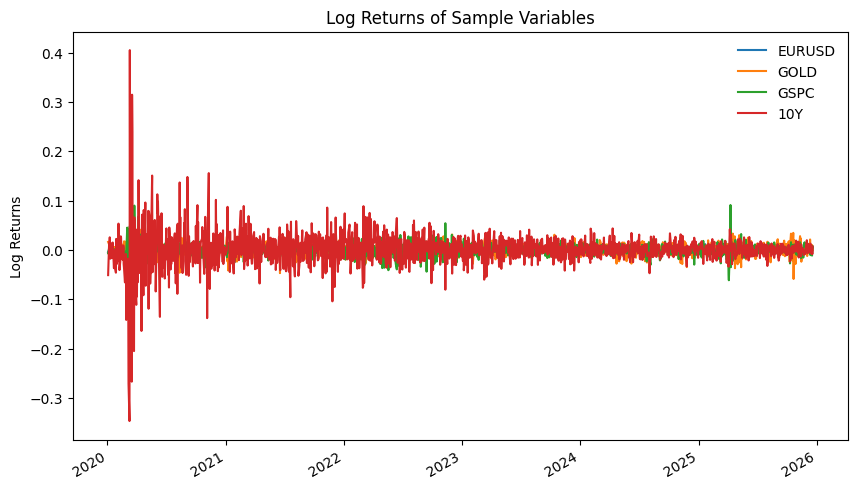

In [21]:
# Data collections and preparations

symbols = ['^GSPC', 'GC=F', '^TNX','EURUSD=X']
names = ['EURUSD', 'GOLD', 'GSPC', '10Y']

def data_wrangling(symbols, names):
  import yfinance as yf
  import pandas as pd
  df = yf.download(symbols, start = '2020-01-01', auto_adjust=True)['Close'].dropna()
  df.columns = names
  df['10Y'] = df['10Y']/100

  # Standardizing the variables for comparison
  df_standardized = (df - df.mean())/df.std()

  # Calculation of log returns
  df_returns = np.log(df/(df.shift(1))).dropna()

  return df, df_standardized, df_returns

# Extracting the sample data
df, df_standardized, df_returns = data_wrangling(symbols, names)

# Plotting the reutrns
df_returns.plot(figsize=(10, 6))
plt.xlabel('')
plt.ylabel('Log Returns')
plt.title('Log Returns of Sample Variables')
plt.legend(frameon = False)
plt.show()

In [32]:
# Calculating the summary stats

def calculate_summary_stats(df_returns):
  import pandas as pd
  from statsmodels.tsa.stattools import adfuller
  from scipy.stats import jarque_bera

  # Calculating summary stats
  all_stats_data = {}

  # ADF test (for stationarity)
  for column in df_returns.columns:
    adf_result = adfuller(df_returns[column])

    # Jarque-Bera Test for Normality
    jb_stat, jb_pvalue = jarque_bera(df_returns[column])
    stats_data = {
        'Count': df_returns[column].count(),
        'Mean': df_returns[column].mean(),
        'Median': df_returns[column].median(),
        'Std Dev': df_returns[column].std(),
        'Skew': df_returns[column].skew(),
        'Kurt': df_returns[column].kurt(),
        'Min': df_returns[column].min(),
        'Max': df_returns[column].max(),
        '1% quantile': df_returns[column].quantile(0.01),
        '99% quantile': df_returns[column].quantile(0.99),
        'ADF Statistic': adf_result[0],
        'ADF p-value': adf_result[1],
        'JB Statistic': jb_stat,
        'JB p-value': jb_pvalue}
    all_stats_data[column] = stats_data
  df_stats = pd.DataFrame(all_stats_data)
  return df_stats.T

# Calculating descriptive statistics
df_summary = calculate_summary_stats(df_returns)
display(df_summary.round(4))

,Count,Mean,Median,Std Dev,Skew,Kurt,Min,Max,1% quantile,99% quantile,ADF Statistic,ADF p-value,JB Statistic,JB p-value
EURUSD,1499.0,0.0000,-0.0001,0.0048,0.0279,2.2484,-0.0281,0.0275,-0.0124,0.0127,-37.5399,0.0,312.7267,0.0
GOLD,1499.0,0.0007,0.0010,0.0107,-0.3664,3.3503,-0.0591,0.0578,-0.0283,0.0275,-16.7979,0.0,728.2109,0.0
GSPC,1499.0,0.0005,0.0010,0.0132,-0.6487,14.7581,-0.1277,0.0909,-0.0363,0.0301,-11.9038,0.0,13610.5877,0.0
10Y,1499.0,0.0005,0.0005,0.0356,0.2565,28.5852,-0.3470,0.4048,-0.0946,0.0888,-6.6067,0.0,50698.0827,0.0


- **ADF Test:** All log returns for EURUSD, GOLD, GSPC, and 10Y appear to be stationary, meaning their statistical properties (like mean and variance) do not change over time, making them suitable for many time series models.

- **Jarque Bera Test:**
  *   **EURUSD:** The p-value for EURUSD is 0.0000. Since this is less than any common significance level (e.g., 0.05 or 0.01), we reject the null hypothesis. This indicates that EURUSD log returns are **not normally distributed**.
  *   **GOLD:** The p-value for GOLD is 0.0000. We reject the null hypothesis, concluding that GOLD log returns are **not normally distributed**.
  *   **GSPC:** The p-value for GSPC is 0.0000. We reject the null hypothesis, confirming that GSPC log returns are **not normally distributed**.
  *   **10Y:** The p-value for 10Y is 0.0000. We reject the null hypothesis, indicating that 10Y log returns are also **not normally distributed**.

  * **Overall:** For all assets tested (EURUSD, GOLD, GSPC, and 10Y), the Jarque-Bera test provides strong evidence to reject the hypothesis of normality. This aligns with the observations from skewness and kurtosis, particularly the high kurtosis values for GSPC and 10Y, which suggested 'fat tails' and a higher likelihood of extreme events than a normal distribution would predict. This non-normality is a common characteristic in financial time series data and has important implications for risk modeling and quantitative analysis, as models assuming normality might underestimate extreme risks.

# Covariance and correlations

In [37]:
# Calculating covariance

df_cov = df_returns.cov()
display(df_cov.round(5))

df_corr = df_returns.corr()
display(df_corr.round(5))


,EURUSD,GOLD,GSPC,10Y
EURUSD,0.00002,0.00000,0.00000,-0.00001
GOLD,0.00000,0.00011,0.00002,-0.00008
GSPC,0.00000,0.00002,0.00017,0.00012
10Y,-0.00001,-0.00008,0.00012,0.00127


,EURUSD,GOLD,GSPC,10Y
EURUSD,1.00000,0.05992,0.01536,-0.06380
GOLD,0.05992,1.00000,0.10823,-0.20433
GSPC,0.01536,0.10823,1.00000,0.25776
10Y,-0.06380,-0.20433,0.25776,1.00000


# Coskewness and cokurtosis

In [45]:
import numpy as np
import pandas as pd

def calculate_normalized_coskewness_matrix(df):
    """
    Calculates a 2D normalized coskewness matrix where the (i,j) entry represents
    E[(Ri - mu_i) * (Rj - mu_j)^2] / (sigma_i * sigma_j^2).
    """
    cols = df.columns
    n_cols = len(cols)
    coskewness_matrix = pd.DataFrame(index=cols, columns=cols, dtype=float)
    df_centered = df - df.mean()
    df_std = df.std()

    for i in range(n_cols):
        for j in range(n_cols):
            term_numerator = (df_centered.iloc[:, i] * (df_centered.iloc[:, j]**2)).mean()
            term_denominator = df_std.iloc[i] * (df_std.iloc[j]**2)
            if term_denominator != 0: # Avoid division by zero
                coskewness_matrix.iloc[i, j] = term_numerator / term_denominator
            else:
                coskewness_matrix.iloc[i, j] = np.nan # Or 0, depending on desired behavior
    return coskewness_matrix

def calculate_normalized_cokurtosis_matrix(df):
    """
    Calculates a 2D normalized cokurtosis matrix where the (i,j) entry represents
    E[(Ri - mu_i)^2 * (Rj - mu_j)^2] / (sigma_i^2 * sigma_j^2).
    """
    cols = df.columns
    n_cols = len(cols)
    cokurtosis_matrix = pd.DataFrame(index=cols, columns=cols, dtype=float)
    df_centered = df - df.mean()
    df_std = df.std()

    for i in range(n_cols):
        for j in range(n_cols):
            term_numerator = ((df_centered.iloc[:, i]**2) * (df_centered.iloc[:, j]**2)).mean()
            term_denominator = (df_std.iloc[i]**2) * (df_std.iloc[j]**2)
            if term_denominator != 0: # Avoid division by zero
                cokurtosis_matrix.iloc[i, j] = term_numerator / term_denominator
            else:
                cokurtosis_matrix.iloc[i, j] = np.nan # Or 0, depending on desired behavior
    return cokurtosis_matrix

print("\n--- Normalized Coskewness Matrix ---")
df_normalized_coskewness = calculate_normalized_coskewness_matrix(df_returns)
display(df_normalized_coskewness.round(4))

print("\n--- Normalized Cokurtosis Matrix ---")
df_normalized_cokurtosis = calculate_normalized_cokurtosis_matrix(df_returns)
display(df_normalized_cokurtosis.round(4))


--- Normalized Coskewness Matrix ---


,EURUSD,GOLD,GSPC,10Y
EURUSD,0.0279,-0.0596,0.0212,0.1596
GOLD,-0.0363,-0.3657,-0.1279,-0.1920
GSPC,-0.1653,0.1577,-0.6474,-0.4660
10Y,-0.1016,0.1174,-0.3592,0.2560



--- Normalized Cokurtosis Matrix ---


,EURUSD,GOLD,GSPC,10Y
EURUSD,5.2299,1.3549,1.8971,2.2593
GOLD,1.3549,6.3267,3.6754,3.0973
GSPC,1.8971,3.6754,17.6813,10.7200
10Y,2.2593,3.0973,10.7200,31.4439


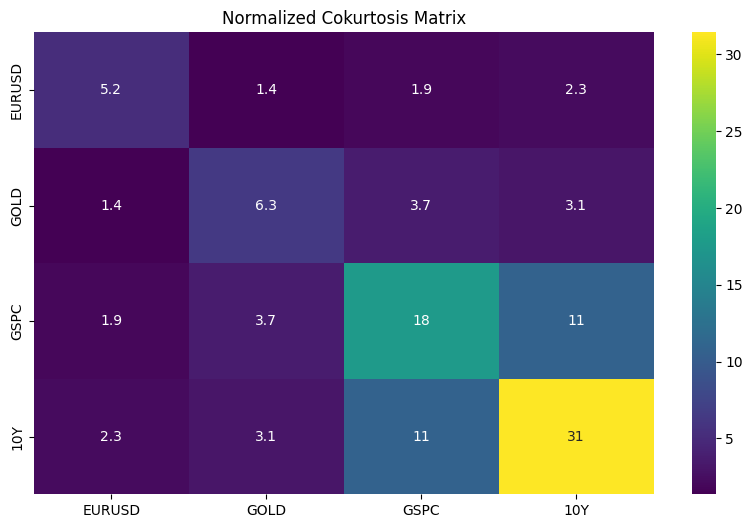

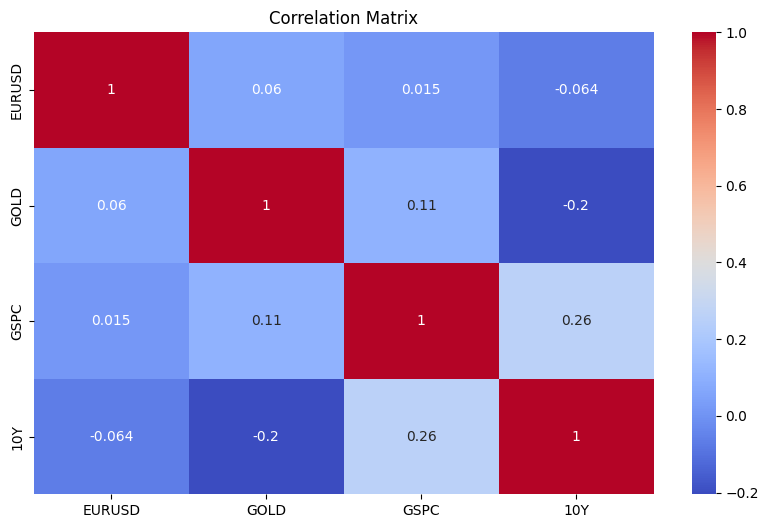

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# Heatmap for df_normalized_cokurtosis
plt.figure(figsize=(10, 6))
sns.heatmap(df_normalized_cokurtosis, annot=True, cmap='viridis')
plt.title('Normalized Cokurtosis Matrix')
plt.show()

# Heatmap for df_corr
plt.figure(figsize=(10, 6))
sns.heatmap(df_corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## Cokurtosis Matrix Insights:
*   **High Diagonal Values (Own Cokurtosis):** The diagonal elements (e.g., EURUSD-EURUSD, GOLD-GOLD) represent the asset's own kurtosis. `10Y` and `GSPC` exhibit significantly higher cokurtosis values (31.44 and 17.68, respectively) compared to `EURUSD` (5.23) and `GOLD` (6.33). This indicates that `10Y` and `GSPC` have fatter tails and are more prone to extreme movements (large gains or losses) than `EURUSD` or `GOLD`.
*   **Inter-Asset Cokurtosis:**
    *   **GSPC-10Y:** There is a relatively high cokurtosis between `GSPC` and `10Y` (10.72). This suggests that extreme movements in the stock market (GSPC) are often accompanied by extreme movements in the 10-year Treasury yield, reflecting significant market-wide events or shifts in investor sentiment that impact both.
    *   **GOLD-GSPC & GOLD-10Y:** `GOLD` shows moderate cokurtosis with `GSPC` (3.68) and `10Y` (3.10). While not as extreme as GSPC-10Y, this still indicates some co-movement during periods of stress or volatility.
    *   **EURUSD:** `EURUSD` generally exhibits lower cokurtosis with other assets, suggesting its extreme movements are less frequently correlated with extreme events in the other markets.

## Correlation Matrix Insights:
*   **Positive Correlations:**
    *   **GSPC-10Y:** `GSPC` and `10Y` have a positive correlation of 0.26. This means that, on average, the stock market and 10-year Treasury yields tend to move in the same direction. An increase in Treasury yields might sometimes signal an improving economic outlook that also benefits stocks.
    *   **GOLD-GSPC & GOLD-EURUSD:** `GOLD` has a weak positive correlation with `GSPC` (0.11) and `EURUSD` (0.06). This suggests a slight tendency for these assets to move together, but the relationship is not strong.
*   **Negative Correlations:**
    *   **GOLD-10Y:** `GOLD` has a notable negative correlation with `10Y` (-0.20). This is a common inverse relationship, where rising interest rates (and thus higher 10Y yields) make non-interest-bearing assets like gold less attractive, and vice-versa.
    *   **EURUSD-10Y:** `EURUSD` also shows a weak negative correlation with `10Y` (-0.064).

### Comparison and Notable Differences:
*   **Higher-Order Dependence:** The cokurtosis matrix provides a more nuanced view of joint extreme movements, which might not be captured by standard correlations. For instance, while `GSPC` and `10Y` have a moderate positive correlation (0.26), their cokurtosis (10.72) is quite high, indicating that when they move together, they often do so in an extreme fashion.
*   **Tail Risk Information:** The much higher diagonal cokurtosis values for `GSPC` and `10Y` compared to `EURUSD` and `GOLD` underscore that these assets contribute more to overall portfolio tail risk due to their propensity for larger extreme events.
*   **Risk Management Implications:** For risk management, particularly during market crises, understanding cokurtosis is crucial. Assets that have low correlation but high cokurtosis might not diversify risk effectively during extreme market events, as their tails move together. For example, while `GOLD` has a negative correlation with `10Y`, their cokurtosis is still positive, indicating that while they generally move in opposite directions, their extreme movements might still be somewhat co-dependent or contribute to overall portfolio kurtosis.

# Returns Distributions

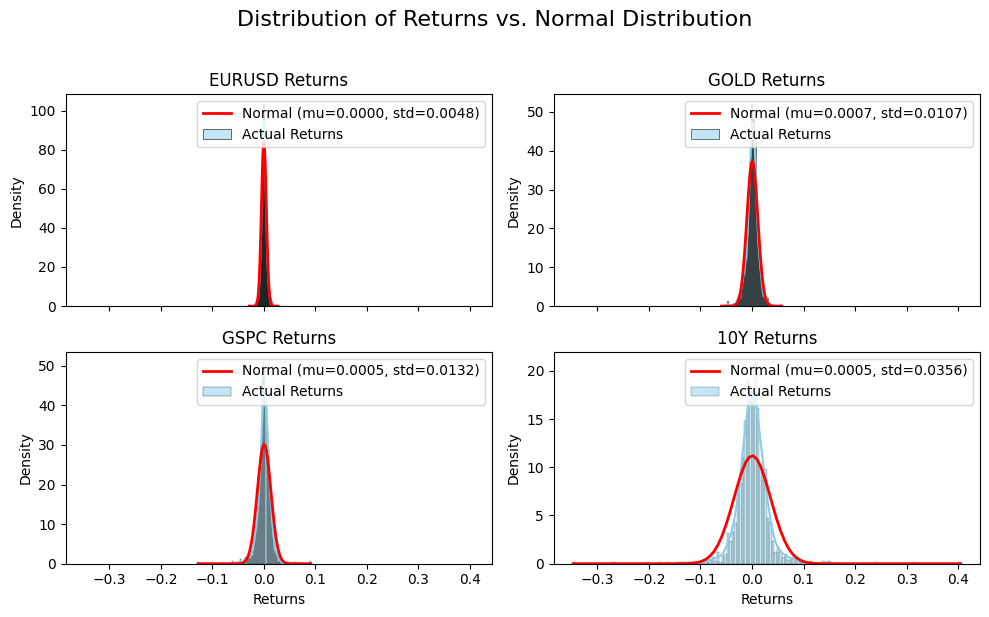

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import numpy as np

# Get the number of assets (assuming df_returns has 4 columns for a 2x2 plot)
num_assets = df_returns.shape[1]

# Create a 2x2 figure and a set of subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 6), sharex=True)
fig.suptitle('Distribution of Returns vs. Normal Distribution', fontsize=16, y=1.02)

# Flatten the axes array for easier iteration
axes_flat = axes.flatten()

for i, column in enumerate(df_returns.columns):
    ax = axes_flat[i] # Get the current Axes object for plotting

    # Plot histogram and KDE for actual returns
    sns.histplot(df_returns[column], ax=ax, stat='density', kde=True, label='Actual Returns', color='skyblue')

    # Calculate mean and standard deviation for the normal distribution
    mu, std = df_returns[column].mean(), df_returns[column].std()

    # Generate x-values for the normal distribution PDF
    # Create a range covering about 3 standard deviations around the mean for a good visual spread
    xmin, xmax = df_returns[column].min(), df_returns[column].max()
    x = np.linspace(xmin, xmax, 100)

    # Plot the normal distribution PDF
    ax.plot(x, norm.pdf(x, mu, std), 'r-', lw=2, label=f'Normal (mu={mu:.4f}, std={std:.4f})')

    ax.set_title(f'{column} Returns')
    ax.set_xlabel('Returns')
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(False)

plt.tight_layout()
plt.show()